In [1]:
import sys
import numpy as np
from openmm import openmm, unit, app

# Coarse-grained water system
* 3000 water molecules (1000 coarse-grained particles)
* Box size = (4 nm)^3

### LJ-12-4 potential (SDK water model)

$U(r)=\frac{3\sqrt{3}}{2}\epsilon \left( \left(\frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^4 \right) - U({r_c}), r<r_c$


In [2]:
n_particle = 1000
mass = 18*3 # dalton
sigma = 0.4371 # nm
epsilon = 0.895*4.184 # kJ/mol
box = np.array([4.0, 4.0, 4.0]) # nm

box_vectors = np.diag(box)
print(box_vectors)

[[4. 0. 0.]
 [0. 4. 0.]
 [0. 0. 4.]]


### Define OpenMM topology (in PDB convention)

In [3]:
top = app.Topology()
chain = top.addChain()
for i in range(1000):
    residue = top.addResidue('WAT', chain)
    top.addAtom('W'+str(i), None, residue)

### Create OpenMM system

In [4]:
system = openmm.System()
system.setDefaultPeriodicBoxVectors(*box_vectors)

# add particles
for i in range(1000):
    system.addParticle(mass)

# define LJ potential
lj = openmm.CustomNonbondedForce('3*sqrt(3)/2*eps*((sig/r)^12-(sig/r)^4)-Uc;'           # potential form
                                 'Uc=3*sqrt(3)/2*eps*((sig/rcut)^12-(sig/rcut)^4);'     # offset at cutoff
                                 'rcut=1.5;'                                            # cutoff distance
                                 'eps=sqrt(eps1*eps2);'                                 # geometric average for epsilon
                                 'sig=(sig1+sig2)/2;')                                  # arithmatic average for sigma
lj.setNonbondedMethod(openmm.CustomNonbondedForce.CutoffPeriodic)# periodic cutoff
lj.setCutoffDistance(1.5)                                        # cutoff distance
lj.addPerParticleParameter('sig')                                # a paramter named "sig" should be provided for each particle
lj.addPerParticleParameter('eps')                                # a paramter named "eps" should be provided for each particle
for i in range(1000):
    lj.addParticle([sigma, epsilon])                             # set parameters "sig" and "eps" for each particle
system.addForce(lj)                                              # add LJ potential to the system


0

### Integrator, thermostat and barostat

In [5]:
# we are going to use Langevin integrator (thermostat)
integrator = openmm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picosecond, 0.01*unit.picosecond)

# add a Monte Carlo barostat
# notice that barostat is termed as a "Force" object in OpenMM
barostat = openmm.MonteCarloBarostat(1.0*unit.bar, 300*unit.kelvin)                   
system.addForce(barostat)

# which platform to use
# could be 'Reference', 'CPU', 'CUDA', 'OpenCL' depending on the hardware
platform = openmm.Platform.getPlatformByName('CPU')

# finally we have a complete definition of the simulation system
sim = app.Simulation(top, system, integrator, platform)

# report properties and trajectory
sim.reporters.append(app.StateDataReporter(sys.stdout, 1000, temperature=True, potentialEnergy=True, step=True, density=True, separator='\t'))
sim.reporters.append(app.PDBReporter('traj.pdb', 200))

### Set the initial positions and velocities

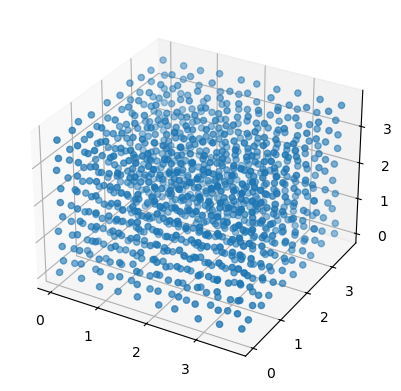

In [6]:
# generate initial positions
import itertools
positions = np.array(list(itertools.product(range(10),range(10), range(10))))/10*box
positions += np.random.rand(n_particle,3)*0.1

# let's take a look of the initial positions
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])

# notice the difference between "Simulation" and "Context"
sim.context.setPositions(positions)
sim.context.setVelocitiesToTemperature(300)

### Calculate energy

In [7]:
# use "State" to retrieve information (position, velocity, force, energy) from the system
state = sim.context.getState(getEnergy=True)
print(state.getPotentialEnergy())

85277.39473724365 kJ/mol


### Enenery minimization

In [8]:
sim.minimizeEnergy()
state = sim.context.getState(getEnergy=True)
print(state.getPotentialEnergy())

-30584.304636001587 kJ/mol


### Run simulation

In [9]:
sim.step(10000)

#"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Density (g/mL)"
1000	-32640.28631591797	291.7751911274761	1.2765727308333439
2000	-34310.33514404297	294.95866780251106	1.165736420627779
3000	-33836.98352432251	295.1250211605094	1.0519223185989854
4000	-32485.933475494385	296.4687375362725	1.0017513398011786
5000	-32266.09055328369	315.2131597433601	0.9939580569535821
6000	-32387.130889892578	296.5272921661952	1.00143614034746
7000	-32242.031272888184	290.14474444691706	0.9863394391206802
8000	-32047.820472717285	295.86479055972677	0.9895223496594996
9000	-32278.645805358887	299.96121032137904	0.9938103817139722
10000	-32199.72776031494	300.51697417528146	0.9914870028315056


### Visualize the trajectory

In [11]:
import mdtraj
import nglview
trj = mdtraj.load('traj.pdb')
view = nglview.show_mdtraj(trj)
view.add_ball_and_stick('all')
view.center(zoom=True)
view

NGLWidget(max_frame=49)

# Another example with GROMACS input files
* 1 Na+ ion, 1 Cl- ion, and 10 water molecules
* Box size = (2.8 nm)^3

### Construct system from GROMACS files
* `conf.gro` Coordinates
* `topol.top` Topology and force field paramters

In [12]:
gro = app.GromacsGroFile('NaCl-conf.gro')
topol = app.GromacsTopFile('NaCl-topol.top', periodicBoxVectors=gro.getPeriodicBoxVectors())
system = topol.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1.0, constraints=app.HBonds, rigidWater=True)

### Add some interesting constraints
* Tether the Na+ ion at the center of the box
* Constrain the distance between Na+ and Cl- ions at 1 nm

In [13]:
# use "CustomExternalForce" to constrain single particle
force1 = openmm.CustomExternalForce('k*((x-1.4)^2+(y-1.4)^2+(z-1.4)^2)')
force1.addPerParticleParameter('k')
force1.addParticle(0,[100*unit.kilojoule_per_mole/unit.nanometer**2])                    # particle 0 is Na+ ion
system.addForce(force1)

# use "CustomBondForce" to constrain distance between two particles
force2 = openmm.CustomBondForce('k*(r-r0)^2')
force2.addPerBondParameter('k')
force2.addPerBondParameter('r0')
force2.addBond(0,1,[5000*unit.kilojoule_per_mole/unit.nanometer**2, 1.0*unit.nanometer]) # particle 1 is Cl- ion
system.addForce(force2)

3

### Run simulation

In [14]:
# simulation
integrator = openmm.LangevinIntegrator(500*unit.kelvin, 5/unit.picosecond, 0.0002*unit.picosecond)
platform = openmm.Platform.getPlatformByName('CPU')
sim = app.Simulation(topol.topology, system, integrator)
sim.reporters.append(app.StateDataReporter(sys.stdout, 2000, temperature=True, potentialEnergy=True, step=True, density=True, separator='\t'))
sim.reporters.append(app.PDBReporter('NaCl-traj.pdb', 200))

sim.context.setPositions(gro.positions)
state = sim.context.getState(getEnergy=True)
print(state.getPotentialEnergy())

sim.step(20000)

2517.9795681206715 kJ/mol
#"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Density (g/mL)"
2000	152.18501826069297	1534.3269962762854	0.018048261600156646
4000	-92.85267989788625	665.5194940300964	0.018048261600156646
6000	-136.12267653061608	483.214259733753	0.018048261600156646
8000	-171.57177974798705	479.91709144998003	0.018048261600156646
10000	-195.4779531691207	435.52945039716985	0.018048261600156646
12000	-281.1614477950804	660.5698190203683	0.018048261600156646
14000	-293.41285134890705	707.7973038516895	0.018048261600156646
16000	-343.3372519291157	630.8476763660173	0.018048261600156646
18000	-363.9388920075303	481.00217110021737	0.018048261600156646
20000	-323.4601637006576	468.9209441095358	0.018048261600156646


### Visualize

In [15]:
import mdtraj
import nglview
trj = mdtraj.load('NaCl-traj.pdb')
view = nglview.show_mdtraj(trj)
view.add_ball_and_stick('all')
view.center(zoom=True)
view

NGLWidget(max_frame=99)